## Test for Feature Eng - LightGBM

In [16]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import datetime
import missingno as msno
import lightgbm as lgb
import xgboost as xgb
from sklearn import preprocessing
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold, TimeSeriesSplit, train_test_split,StratifiedKFold
import gc
from statistics import mean

# Any results you write to the current directory are saved as output.

### Setup Cross Validation
1. Divide Train set in subsets (Training set itself + Local Test set)
2. Define Validation Metric (in our case it is ROC-AUC)
3. Stop training when Validation metric stops improving
4. Take average of each fold's prediction for the Local Test set.

In [17]:
train_full = pd.read_pickle('data/train_feat.pkl')
test_full = pd.read_pickle('data/test_feat.pkl')

# Label Encoding for categoricals
for f in test_full.columns:
    if train_full[f].dtype=='object' or test_full[f].dtype=='object': 
        train_full[f] = train_full[f].fillna('unseen_before_label')
        test_full[f]  = test_full[f].fillna('unseen_before_label')
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(train_full[f].values) + list(test_full[f].values))
        train_full[f] = lbl.transform(list(train_full[f].values))
        test_full[f] = lbl.transform(list(test_full[f].values)) 

# Fill NA's for numerics
train_full = train_full.fillna(-999)
test_full = test_full.fillna(-999)

In [18]:
rm_cols = [
    'TransactionID','TransactionDT', 
    'isFraud'                         
]

# Final features
features_columns = [col for col in list(train_full.columns) if col not in rm_cols]

In [19]:
X = train_full[features_columns]
y = train_full['isFraud']

# # Split holdout as 15% of the train set
# X, X_holdout, y, y_holdout = train_test_split(train_full[features_columns], train_full['isFraud'], 
#                                               test_size=0.15, random_state=42, shuffle=False)
# #                                               stratify = train_full['isFraud'])

del train_full
gc.collect()

85

In [20]:
params = {
                    'objective':'binary',
                    'boosting_type':'gbdt',
                    'metric':'auc',
                    'n_jobs':-1,
                    'learning_rate':0.01, # speed up the learning rate a bit - might sacrifice a bit of accuracy
                    'num_leaves':2**8, # reduce number of leaves to reduce overfitting
                    'max_depth': -1, # max_depth should be constrained, -1 would mean unconstrained
                    'tree_learner':'serial',
                    'colsample_bytree': 0.7,
                    'subsample_freq':1,
                    'subsample':0.7,
                    'n_estimators':800,
                    'max_bin':255, # less bins if overfitting
                    'verbose':-1,
                    'seed': 2019,
                    'early_stopping_rounds':100,
#                     'lambda_l1':5,
#                     'lambda_l2':5,
                } 

In [22]:
NFOLDS =5
# folds = StratifiedKFold(n_splits=NFOLDS,random_state=123,shuffle=False) # split by stratified folds. Do shuffle =F
folds = KFold(n_splits=NFOLDS,random_state=123,shuffle=False) # split by stratified folds
# folds = TimeSeriesSplit(n_splits=NFOLDS) # split by time - try timeseries split, perhaps less overfitting? result: worse overfitting

aucs = []
clfs=[]
pred_len = len(test_full)
prediction = np.zeros(pred_len)

for fold, (trn_idx, test_idx) in enumerate(folds.split(X,y)):
    print('Training on fold {}'.format(fold + 1))
    
    trn_data = lgb.Dataset(data=X.iloc[trn_idx], label=y.iloc[trn_idx])
    val_data = lgb.Dataset(data=X.iloc[test_idx], label=y.iloc[test_idx])
    clf = lgb.train(params, 
                    trn_data, 
                    valid_sets = [trn_data, val_data], 
                    verbose_eval=200)
    
    print('AUC for validation fold {}: {}'.format(fold+1, clf.best_score['valid_1']['auc']))
    aucs.append(clf.best_score['valid_1']['auc'])
    
#     holdout_pred = clf.predict(X_holdout)
#     print('AUC for holdout set - fold ', roc_auc_score(y_holdout, holdout_pred))
    
    prediction += clf.predict(test_full[features_columns])

print("Cross Validation AUC: ", sum(aucs)/NFOLDS)
final_predictions = prediction/NFOLDS

Training on fold 1
Training until validation scores don't improve for 100 rounds.
[200]	training's auc: 0.958653	valid_1's auc: 0.892569
[400]	training's auc: 0.985236	valid_1's auc: 0.909282
[600]	training's auc: 0.994526	valid_1's auc: 0.917035
[800]	training's auc: 0.997942	valid_1's auc: 0.920827
Did not meet early stopping. Best iteration is:
[800]	training's auc: 0.997942	valid_1's auc: 0.920827
AUC for validation fold 1: 0.9208272970261434
Training on fold 2
Training until validation scores don't improve for 100 rounds.
[200]	training's auc: 0.95866	valid_1's auc: 0.909656
[400]	training's auc: 0.986576	valid_1's auc: 0.925803
[600]	training's auc: 0.995719	valid_1's auc: 0.932414
[800]	training's auc: 0.998512	valid_1's auc: 0.935288
Did not meet early stopping. Best iteration is:
[800]	training's auc: 0.998512	valid_1's auc: 0.935288
AUC for validation fold 2: 0.9352879617017733
Training on fold 3
Training until validation scores don't improve for 100 rounds.
[200]	training's 

Using 470 Features -> Slight improvement: CV: 0.9340; LB: 0.9437

** Data leakage in feature engineering process found when creating frequency encoding - FIXED

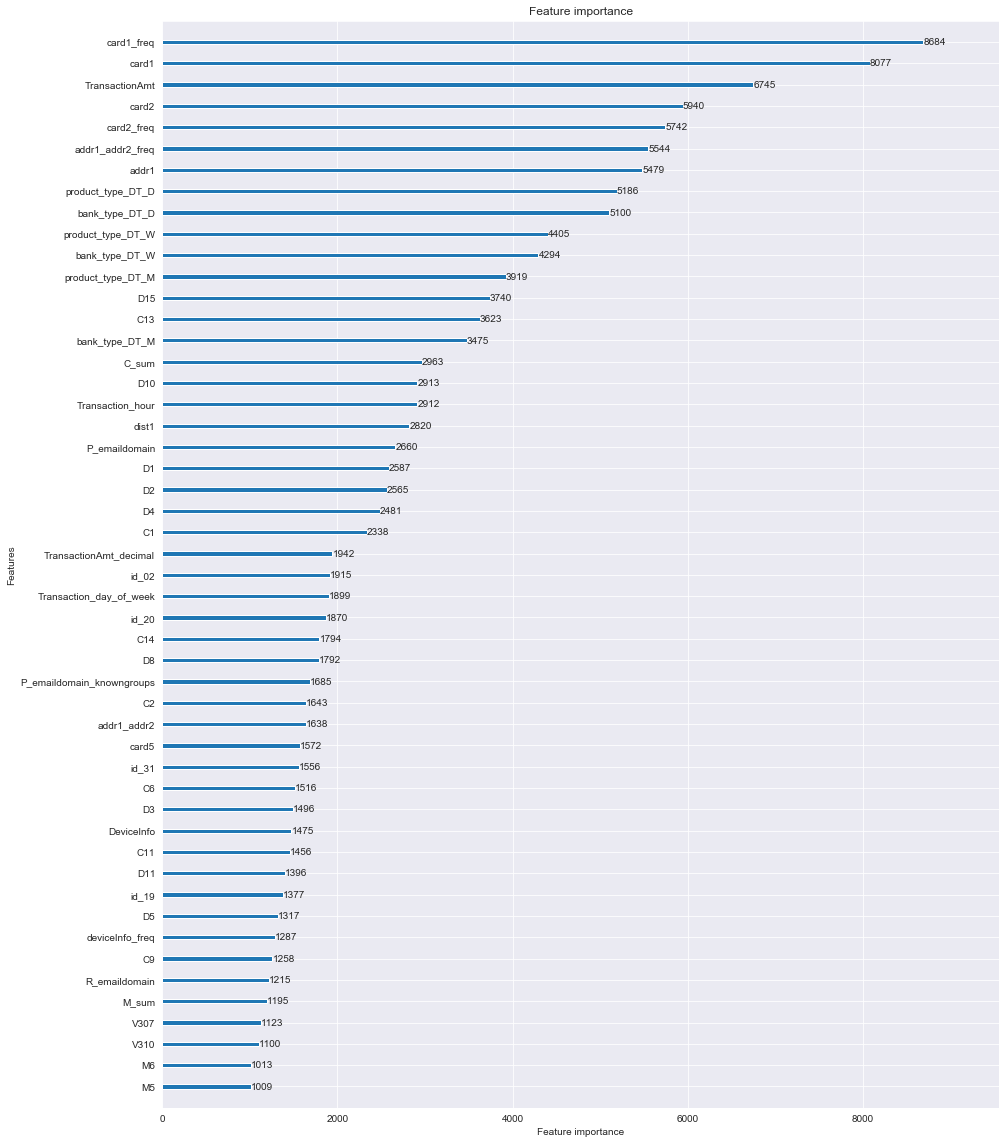

In [23]:
fig, ax = plt.subplots(figsize=(15, 20))
lgb.plot_importance(clf,max_num_features=50,ax=ax)
# for i in range(NFOLDS):
#     fig, ax = plt.subplots(figsize=(15, 20))
#     xgb.plot_importance(clfs[i],max_num_features=50,ax=ax)

In [24]:
sample_submission = pd.read_csv('data/sample_submission.csv', index_col='TransactionID')
sample_submission['isFraud'] = prediction
sample_submission.to_csv('data/lightgbm_470feat.csv')